# Translation with a sequence to sequence network and attention

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import indexesFromSentence, tensorFromSentence, tensorsFromPairs, train, evaluate, asMinutes, timeSince

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the data

The data used here consists of thousands of English to French translation pairs.

The data can ge downloaded from https://download.pytorch.org/tutorial/data.zip<br>
We need the file "eng-fra.txt" file.

The preprocessing of the data consists in three main steps:
 * Read the text file and split into lines, then split lines into pairs
 * Normalize the text and filter by length and content (this second step is optional)
 * Make word lists from sentences in pairs

In order to perform these steps, additional / auxiliary functions and/or classes are needed. They are defined as follows.

Class 'Lang' is created to keep track of the indices of the words. These indices must be unique. The 'Lang' class have dictionaries to map each word to its index and viceversa. It also has a counter of each word, so that it will be easy to detect rare words.

In [3]:
SOS_token=0
EOS_token=1

class Lang:
    def __init__(self,name):
        self.name = name
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2count = {}
        self.n_words = 2 # count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words +=1
        else:
            self.word2count[word] += 1

Turn the Unicode characters to ASCII. Also, lowercase everything and trim punctuation

In [2]:
# convert unicode to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# lowercase trim and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf8').read().strip().split('\n')
    # split every line in to pairs and then normalize the pairs
    pairs =  [[normalizeString(string) for string in l.split('\t')] for l in lines]

    # reverse pairs (if needed) and create Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

To train something quickly, the sentences to work with (and to predict) will be limited to sentences no longer than 10 words as well as sentences that start with "I am" or "He is" (accountin for apostrophes replaced earlier)

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

As already explained before, the process for preparing the data is:
 * Read text file and split into lines, split lines into pairs
 * Normalize text, filter by length and content
 * Make word lists from sentences in pairs


In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['elle est rapide en tout .', 'she is quick at everything .']


## Seq2Seq Model

A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

<img src="images/seq2seq.png" width=40%>

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

<img src="images/encoder-network.png" width=15%>

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output,hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

#### Simple Decoder
In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the <u>decoder</u>.<br>
At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

<img src="images/decoder-network.png" width=15%>

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
        

#### Attention Decoder

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called `attn_applied` in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

<img src="images/1152PYf.png" width=25%>

Calculating the attention weights is done with another feed-forward layer `attn`, using the decoder’s input and previous hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

<img src="images/attention-decoder-network.png" width=35%>

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = dropout
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout_l = nn.Dropout(dropout)
        self.gru  = nn.GRU(hidden_size, hidden_size)
        self.out =nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.dropout_l(self.embedding(input).view(1, 1, -1))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0],hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        attn_combine = F.relu(self.attn_combine(torch.cat((embedded[0],attn_applied[0]), 1)).unsqueeze(0))

        output, new_hidden = self.gru(attn_combine, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, new_hidden, attn_weights



## Training

To prepare the data, there are three functions on the `utils.py` file:
 * indexesFromSentence
 * tensorFromSentence
 * tensorsFromPair
These functions are implemented to convert each pair to input tensors (which contains the indexes of the words in the input sentences) and target tensor (which contains the indexes of the words in the target sentences). While creating these vectors we will append the EOS token to both sequences.

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the `<SOS>` token as its first input, and the last hidden state of the encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as each next input, instead of using the decoder's guess as the next input. Using teacher forcing causes it to converge faster but [when the trained network is exploited, it may exhibit instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation -intuitively it has learned to represent the output grammar and can "pick up" the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn `teacher_forcing_ratio` up to use more of it (see the train function in the `utils.py` for details).

The whole training process looks like this:
 * Start a timer
 * Initialize optimizers and criterion
 * Create set of training pairs
 * Start empty losses array for plotting

Then we call the `train` function many times and occasionally print the progrees (percentage of examples, time so far, estimated time) and average loss.

In [10]:
def trainIters (encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, attention=False, device='cpu'):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPairs(random.choice(pairs), input_lang, output_lang, device=device) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter -1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, input_tensor, target_tensor,
            max_lenth=MAX_LENGTH, device=device, attention=attention, teaching_forcing_ratio=1.0)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_average = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) % .4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_average))

        if iter % plot_every == 0:
            plot_loss_average = plot_loss_total / plot_every
            plot_losses.append(plot_loss_average)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results


In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are not targets so we simply feed the decoder's predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOStoken we stop there. We also store the decoder's attention outputs for display later (for detail implementations check the `evaluate` function on the `utils.py` script).

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [12]:
def evalauteRandomly(encoder, decoder, n=10, attention=False, device='cpu'):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        if attention:
            output_words, decoder, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang, attention=attention, device=device)
        else:
            output_words, decoder = evaluate(encoder, decoder, pair[0], input_lang, output_lang, attention=attention, device=device)
        output_sentence = ''.join(output_words)
        print('>', output_sentence)
        print('')

## Training and Evaluating

Let's compare the training times and evaluation of a seq2seq model with and without attention:

In [13]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout=0.2, max_length=MAX_LENGTH).to(device)

0m 52s (-12m 10s) (5000 6%)  2.6984
1m 41s (-10m 58s) (10000 13%)  2.0318
2m 30s (-10m 0s) (15000 20%)  1.7298
3m 19s (-9m 7s) (20000 26%)  1.4885
4m 8s (-8m 16s) (25000 33%)  1.2900
4m 56s (-7m 25s) (30000 40%)  1.1235
5m 45s (-6m 35s) (35000 46%)  0.9847
6m 34s (-5m 45s) (40000 53%)  0.8652
7m 23s (-4m 55s) (45000 60%)  0.7801
8m 12s (-4m 6s) (50000 66%)  0.6650
9m 1s (-3m 16s) (55000 73%)  0.5756
9m 50s (-2m 27s) (60000 80%)  0.5125
10m 39s (-1m 38s) (65000 86%)  0.4460
11m 27s (-0m 49s) (70000 93%)  0.3943
12m 17s (-0m 0s) (75000 100%)  0.3294


<Figure size 432x288 with 0 Axes>

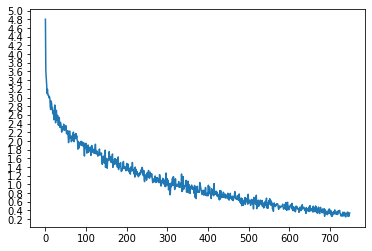

In [14]:
trainIters(encoder1, decoder, 75000, print_every=5000, device=device)

1m 20s (-18m 42s) (5000 6%)  2.6189
2m 36s (-16m 57s) (10000 13%)  1.9508
3m 52s (-15m 30s) (15000 20%)  1.6558
5m 9s (-14m 10s) (20000 26%)  1.4271
6m 25s (-12m 51s) (25000 33%)  1.2170
7m 42s (-11m 33s) (30000 40%)  1.0861
8m 58s (-10m 15s) (35000 46%)  0.9671
10m 14s (-8m 57s) (40000 53%)  0.8599
11m 31s (-7m 40s) (45000 60%)  0.7469
12m 47s (-6m 23s) (50000 66%)  0.6753
14m 4s (-5m 7s) (55000 73%)  0.6346
15m 22s (-3m 50s) (60000 80%)  0.5617
16m 39s (-2m 33s) (65000 86%)  0.4894
17m 56s (-1m 16s) (70000 93%)  0.4492
19m 13s (-0m 0s) (75000 100%)  0.4035


<Figure size 432x288 with 0 Axes>

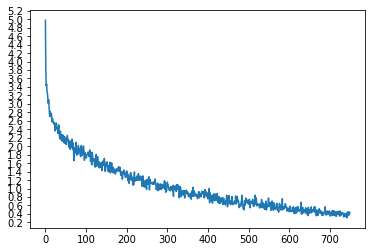

In [15]:
trainIters(encoder2, attn_decoder, 75000, print_every=5000, attention=True, device=device)

### Evaluation of seq2seq with a simple decoder

In [16]:
evalauteRandomly(encoder1, decoder, attention=False, device=device)

> nous sommes tellement fieres de vous !
= we re so proud of you !
> weresoproudofyou!<EOS>

> j ai peur des ours .
= i am afraid of bears .
> iamafraidofdogs.<EOS>

> nous restons .
= we re staying .
> werestaying.<EOS>

> c est une veritable artiste .
= she s a true artist .
> shesatrueartist.<EOS>

> tu es dur .
= you re tough .
> youretough.<EOS>

> j en ai assez de vos recriminations .
= i m sick of your complaints .
> imsickofyourcomplaints.<EOS>

> nous sommes creves .
= we re pooped .
> werepooped.<EOS>

> je n en suis pas si sure !
= i m not so sure .
> imnotsosure.<EOS>

> vous etes tres directes .
= you re very direct .
> youreveryemotional.<EOS>

> je ne m y rends pas .
= i m not going .
> imnotgoing.<EOS>



### Evaluation of seq2seq with an attention decoder

In [17]:
evalauteRandomly(encoder2, attn_decoder, attention=True, device=device)

> il lit un roman en ce moment .
= he s reading a novel right now .
> hesreadinganovelrightnow.<EOS>

> je vais avoir trente ans en octobre .
= i m turning thirty in october .
> imthirtyallthisinlove.<EOS>

> nous sommes anxieux .
= we re anxious .
> weresurprised.<EOS>

> il est pret a travailler .
= he is ready to work .
> heisreadytowork.<EOS>

> c est un acteur .
= he is an actor .
> heisapoet.<EOS>

> je me rejouis de vous contenter .
= i m glad i make you happy .
> imgladtomakeyou.<EOS>

> je ne suis pas si occupe que ca .
= i m not all that busy .
> imnotallthatbusy.<EOS>

> elle ecrit une lettre maintenant .
= she is writing a letter now .
> sheisamemberinaheadache.<EOS>

> je suis vraiment desole .
= i am truly sorry .
> imverysorry.<EOS>

> vous etes mignonnes dans votre genre .
= you re kind of cute .
> youreuptomyopinion.<EOS>



## Visualizing Attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

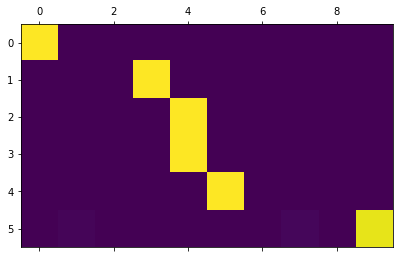

In [18]:
output_words, h, attentions = evaluate(
    encoder2, attn_decoder, "je suis trop froid .", input_lang, output_lang, attention=True, device=device)
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


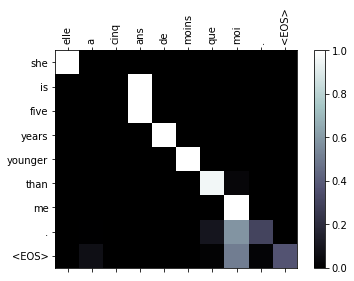

input = elle est trop petit .
output = she s too loud . <EOS>


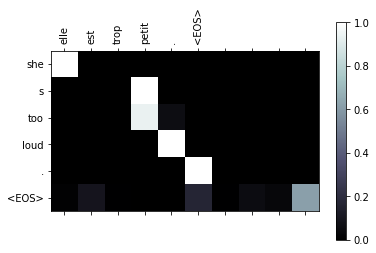

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


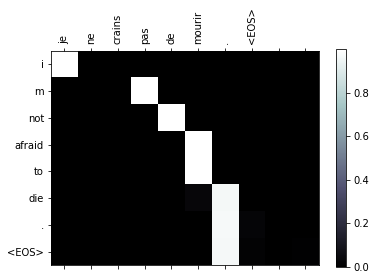

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


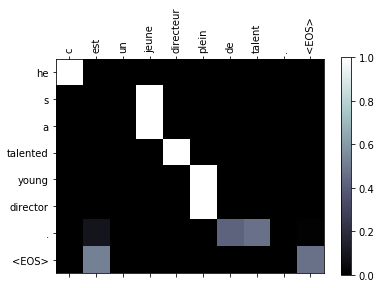

In [19]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, device=device):
    output_words, h, attentions = evaluate(
        encoder2, attn_decoder, input_sentence, input_lang, output_lang, attention=True, device=device)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")